## Applying Tabular Methods

#### Comparing Q Learning And Double Q Learning - Stochastic

### Stochastic Q Learning

Import Statements

In [ ]:
import gym as gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pickle

In [ ]:
class StochasticFrozenLakeEnv(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self, gamma=0.9, alpha=0.1, max_timestamp=10):
        self.gamma = gamma
        self.alpha = alpha
        
        self.obs_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timestamp = max_timestamp
        self.timestep = 0

        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.goal_loc = np.asarray([3, 3])
        self.gem_loc = [np.asarray([0, 2]), np.asarray([3, 2])]
        self.hole_loc = [np.asarray([1, 3]), np.asarray([2, 0])]

        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.penalty_counter = 0
        self.flag_out_grid = 0

    def step(self, action):
        self.prev_state = np.copy(self.state)
        self.prev_action = action
        self.flag_out_grid = 0

        randomness = [0.35, 0.15, 0.35, 0.15]  # probability for each action
        action = np.random.choice(4,p=randomness)

        if action == 0:
            self.myskater[0] += 1
        elif action == 1:
            self.myskater[0] -= 1
        elif action == 2:
            self.myskater[1] += 1
        elif action == 3:
            self.myskater[1] -= 1

        self.myskater = np.clip(self.myskater, 0, 3)

        prev_state_positions = np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions) > 0:
            if np.array_equal(self.myskater, prev_state_positions[0]):
                while action == self.prev_action:
                    action = np.random.choice(4, p=randomness)
                self.flag_out_grid = 1

        self.state = np.zeros((4, 4))
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        obs = self.state.flatten()
        reward = self.calculate_reward()
        penalty = any(np.array_equal(self.myskater, pos) for pos in self.hole_loc)
        if penalty:
            self.penalty_counter += 1
        self.timestep += 1

        terminated = True if np.array_equal(self.myskater, self.goal_loc) else self.timestep >= self.max_timestamp
        truncated = True if np.any((self.myskater < 0) | (self.myskater > 3)) else False
        if terminated or truncated:
            self.flag_out_grid=1
            self.state = np.copy(self.prev_state) 

            # Check if there are any positions with a value of 0.2
            positions_with_value_0_2 = np.argwhere(self.state == 0.2)

            if len(positions_with_value_0_2) > 0:
                # Ensure that the index is within bounds
                index = np.random.randint(len(positions_with_value_0_2))
                self.myagent = positions_with_value_0_2[index]
                
        info = {}

        return self.state.flatten(), reward, terminated, truncated, info
        
    def reset(self, **kwargs):
        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8

        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.flag_out_grid = 0 
        
        obs = self.state.flatten()
        self.timestep = 0
        info = {}
        self.penalty_counter = 0
        return obs, info

    def calculate_reward(self):
        prev_myskateritions = np.argwhere(self.prev_state == 0.2)
        if prev_myskateritions.size == 0:
            prev_myskaterition = self.myskater
        else:
            prev_myskaterition = prev_myskateritions[0]

        # Calculating distance to goal before and after the step
        prev_distance_to_goal = np.linalg.norm(self.goal_loc - prev_myskaterition)
        current_distance_to_goal = np.linalg.norm(self.goal_loc - self.myskater)


        ## REWARDS SET #############
        if np.array_equal(self.myskater, self.goal_loc):
            reward = 10  # Positive reward for reaching goal
        elif np.array_equal(self.myskater, self.hole_loc[0]):
            reward = -5  # negative reward for reaching holes 1
        elif np.array_equal(self.myskater, self.hole_loc[1]):
            reward = -6   # negative reward for reaching holes 2
        elif np.array_equal(self.myskater, self.gem_loc[0]):
            reward = 5   # positive reward for reaching gems 1
        elif np.array_equal(self.myskater, self.gem_loc[1]):
            reward = 6  # positive reward for reaching gems 2
        elif current_distance_to_goal < prev_distance_to_goal:
            reward = 1  # Positive reward for moving closer to goal
        elif current_distance_to_goal > prev_distance_to_goal:
            reward = -1  # Negative reward for moving away to goal
        else:
            reward = -0.1  # Slight negative reward for no change
        ##########################
        
        return reward
    
    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig, ax = plt.subplots()
        plt.title('Frozen Lake Environment')

        # Load and display the background image
        background_img = plt.imread('images/frozen_lake.jpg')
        ax.imshow(background_img, extent=(-0.5, 3.5, -0.5, 3.5), origin='upper')

       
        skater_img = plt.imread('images/icons8-skateboard-100.png')
        hole_img = plt.imread('images/icons8-hole-100.png')
        gem_img = plt.imread('images/icons8-gems-100.png')
        goal_img = plt.imread('images/icons8-flag-100.png')
        skater_hole_drown_img = plt.imread('images/agent_hole_drown.png')
        skater_gem_lottery_img = plt.imread('images/agent_gems_lottery.png')
        agent_flag_winner_img = plt.imread('images/agent_flag_winner.png')
        agent_grid_cross_img = plt.imread('images/agent_grid_cross.png')

        # Plot Skater
        myskater = self.myskater
        if self.flag_out_grid:
            skater_img = agent_grid_cross_img
        agent_box = AnnotationBbox(OffsetImage(skater_img, zoom=0.4), myskater, frameon=False)
        ax.add_artist(agent_box)

        # Plot Holes
        for hole_loc in self.hole_loc:
            hole_loc = hole_loc
            if np.array_equal(self.myskater, hole_loc):
                hole_img = skater_hole_drown_img
            else:
                hole_img = plt.imread('images/icons8-hole-100.png')
            rock_box = AnnotationBbox(OffsetImage(hole_img, zoom=0.4), hole_loc, frameon=False)
            ax.add_artist(rock_box)

        # Plot Gems
        for gem_loc in self.gem_loc:
            gem_loc = gem_loc
            if np.array_equal(self.myskater, gem_loc):
                gem_img = skater_gem_lottery_img
            else:
                gem_img = plt.imread('images/icons8-gems-100.png')
            battery_box = AnnotationBbox(OffsetImage(gem_img, zoom=0.4), gem_loc, frameon=False)
            ax.add_artist(battery_box)

        # Plot goal
        goal_loc = self.goal_loc
        goal_loc = self.goal_loc
        if np.array_equal(self.myskater, goal_loc):
            goal_img = agent_flag_winner_img
        else:
            goal_img = plt.imread('images/icons8-flag-100.png')
        goal_box = AnnotationBbox(OffsetImage(goal_img, zoom=0.4), goal_loc, frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5, 4.5, 1))
        plt.yticks(np.arange(-0.5, 4.5, 1))
        plt.gca().set_xticklabels(np.arange(-0.5, 4.5, 1))
        plt.gca().set_yticklabels(np.arange(-0.5, 4.5, 1))
        plt.show()

    def obs_space_to_index(self, obs):
        myskater = np.argwhere(obs.reshape(4, 4) == 0.2)
        if myskater.size == 0:
            return 0 
        return myskater[0, 0] * 4 + myskater[0, 1]


In [ ]:
env_stoc_q = StochasticFrozenLakeEnv()

epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
gamma = 0.95  # Discount factor
alpha = 0.15  # Learning rate
decay_rate = 0.995  # Epsilon decay rate per episode
total_episodes = 1000 
max_timestamp = 10
qt = np.zeros((env_stoc_q.obs_space.n, env_stoc_q.action_space.n))

rewards_epi = []
epsilon_values = []
steps_per_episode = []
penalties_per_episode = []

final_state = None
for episode in range(total_episodes):
    state, _ = env_stoc_q.reset()
    state_index = env_stoc_q.obs_space_to_index(state)
    total_rewards = 0
    total_steps = 0  
    action = env_stoc_q.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[state_index])

    while True:
        next_state, reward, terminated, truncated, _ = env_stoc_q.step(action)
        total_steps += 1 
        next_strt_idx = env_stoc_q.obs_space_to_index(next_state)
        next_action = env_stoc_q.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[next_strt_idx])
        qt[state_index, action] = qt[state_index, action] + alpha * (reward + gamma * qt[next_strt_idx, next_action] - qt[state_index, action])
        state_index, action = next_strt_idx, next_action
        total_rewards += reward
        
        if terminated or truncated:
            break
    
    penalties_per_episode.append(env_stoc_q.get_penalty_count())  
    
    # Q-table for every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode: {episode + 1}")
        print("Q-table:")
        print(qt)

        # average penalties
        avg_penalty = np.mean(penalties_per_episode[-100:])
        print(f"Average Penalties in Last 100 Episodes: {avg_penalty}")

    epsilon = max(epsilon_min, epsilon * decay_rate)
    epsilon_values.append(epsilon)
    rewards_epi.append(total_rewards)
    steps_per_episode.append(total_steps)

    if (episode + 1) % 100 == 0:
        average_steps = np.mean(steps_per_episode[-100:])
        print(f"Episode: {episode + 1}, Average Steps: {average_steps}")

    if episode == total_episodes - 1:
        final_state = env_stoc_q.state


Episode: 100
Q-table:
[[ 0.884182    1.30796692  2.78665189  1.49728285]
 [ 2.75724562  2.5129886   4.8144802   1.92199061]
 [ 0.          0.          0.          0.        ]
 [-0.37141941 -0.96013042 -1.00686475 -1.46901917]
 [-3.34695982 -2.64672654 -3.06026345 -0.40319783]
 [ 0.2864261   0.43104706  0.51565151  1.22370963]
 [-1.01743945  1.06395633  2.1270275   2.51635968]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.35781502 -0.13008573 -0.57622004 -0.16558562]
 [ 4.42107267  0.03355901  2.49717014  1.27693664]
 [ 0.23483546  2.21813139  0.06951418  0.79570972]
 [-1.83336079 -1.69245627 -0.89541104 -2.18432665]
 [ 2.67283586  2.76507066  2.03724955  4.05543027]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Average Penalties in Last 100 Episodes: 1.22
Episode: 100, Average Steps: 9.7
Episode: 200
Q-table:
[[ 2.10676134  3.31341259  4.64971965  1.51658731]
 [ 3.83166

In [ ]:
env_stoc = StochasticFrozenLakeEnv()
epsilon = 1.0  
epsilon_min = 0.01  
gamma = 0.95 
alpha = 0.15 
decay_rate = 0.995  
total_episodes = 1000
max_timestamp = 10

qt1 = np.zeros((env_stoc.obs_space.n, env_stoc.action_space.n))  # Q-table 1 initialization
qt2 = np.zeros((env_stoc.obs_space.n, env_stoc.action_space.n))  # Q-table 2 initialization

rewards_epi = []
epsilon_values = []
steps_per_episode = []
penalties_per_episode = []

final_state = None

for episode in range(total_episodes):
    state, _ = env_stoc.reset()
    state_index = env_stoc.obs_space_to_index(state)
    total_rewards = 0
    total_steps = 0

    while True:
        total_steps += 1
        action = env_stoc.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax((qt1[state_index] + qt2[state_index]) / 2)
        next_state, reward, terminated, truncated, _ = env_stoc.step(action)
        next_strt_idx = env_stoc.obs_space_to_index(next_state)
        if np.random.uniform(0, 1) < 0.5:
            qt1[state_index, action] += alpha * (reward + gamma * qt2[next_strt_idx, np.argmax(qt1[next_strt_idx])] - qt1[state_index, action])
        else:
            qt2[state_index, action] += alpha * (reward + gamma * qt1[next_strt_idx, np.argmax(qt2[next_strt_idx])] - qt2[state_index, action])
        state_index = next_strt_idx
        total_rewards += reward
        if terminated or truncated or total_steps >= max_timestamp:
            break

    penalties_per_episode.append(env_stoc.get_penalty_count())
    if (episode + 1) % 100 == 0:
        print(f"Episode: {episode + 1}")
        print("Q-table 1:")
        print(qt1)
        print("Q-table 2:")
        print(qt2)
        avg_penalty = np.mean(penalties_per_episode[-100:])
        print(f"Average Penalties in Last 100 Episodes: {avg_penalty}")

    epsilon = max(epsilon_min, epsilon * decay_rate)
    epsilon_values.append(epsilon)
    rewards_epi.append(total_rewards)
    steps_per_episode.append(total_steps)

    if (episode + 1) % 100 == 0:
        average_steps = np.mean(steps_per_episode[-100:])
        print(f"Episode: {episode + 1}, Average Steps: {average_steps}")

    if episode == total_episodes - 1:
        final_state = env_stoc.state

Episode: 100
Q-table 1:
[[ 1.11876402  1.51904539  2.02564955 -0.30197225]
 [ 2.40096921  0.51652121  2.3400676   1.93445032]
 [ 0.          0.          0.          0.        ]
 [-0.34859099 -0.39298902 -1.87440325  0.23584823]
 [-0.92164398 -0.76482213  0.30620877 -3.05128047]
 [ 0.22510251  0.20302604  0.33330131  0.1004107 ]
 [-1.42245604  0.39266994 -0.92009502  1.24509206]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.10793039  0.05598952  0.73769959  0.03305302]
 [ 1.70018183  2.52154465  1.68746312  0.73752489]
 [ 0.07839401 -0.06573514  2.54379416  3.31739994]
 [ 0.59473776  0.08548347  0.85147147  0.3979303 ]
 [ 2.31340546  1.38509006  0.35694545  0.95953378]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Q-table 2:
[[-0.34282785  0.58406561  0.13837072  1.4922349 ]
 [ 1.20362517  2.48805914  1.5200613   2.52305169]
 [ 0.          0.          0.          0.     

In [ ]:
# Q-Learning Training Loop
q_rewards = []
for episode in range(total_episodes):
    state, _ = env_stoc.reset()
    state_index = env_stoc.obs_space_to_index(state)
    total_rewards = 0
    total_steps = 0
    action = env_stoc.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[state_index])
    while True:
        next_state, reward, terminated, truncated, _ = env_stoc.step(action)
        total_steps += 1 
        next_strt_idx = env_stoc.obs_space_to_index(next_state)
        next_action = env_stoc.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax(qt[next_strt_idx])
        qt[state_index, action] = qt[state_index, action] + alpha * (reward + gamma * qt[next_strt_idx, next_action] - qt[state_index, action])
        state_index, action = next_strt_idx, next_action
        total_rewards += reward
        if terminated or truncated:
            break
    q_rewards.append(total_rewards)


# Double Q-learning Training Loop
double_q_rewards = []
for episode in range(total_episodes):
    state, _ = env_stoc.reset()
    state_index = env_stoc.obs_space_to_index(state)
    total_rewards = 0
    total_steps = 0
    while True:
        total_steps += 1
        action = env_stoc.action_space.sample() if np.random.uniform(0, 1) < epsilon else np.argmax((qt1[state_index] + qt2[state_index]) / 2)
        next_state, reward, terminated, truncated, _ = env_stoc.step(action)
        next_strt_idx = env_stoc.obs_space_to_index(next_state)
        if np.random.uniform(0, 1) < 0.5:
            qt1[state_index, action] += alpha * (reward + gamma * qt2[next_strt_idx, np.argmax(qt1[next_strt_idx])] - qt1[state_index, action])
        else:
            qt2[state_index, action] += alpha * (reward + gamma * qt1[next_strt_idx, np.argmax(qt2[next_strt_idx])] - qt2[state_index, action])
        state_index = next_strt_idx
        total_rewards += reward
        if terminated or truncated or total_steps >= max_timestamp:
            break
    double_q_rewards.append(total_rewards)


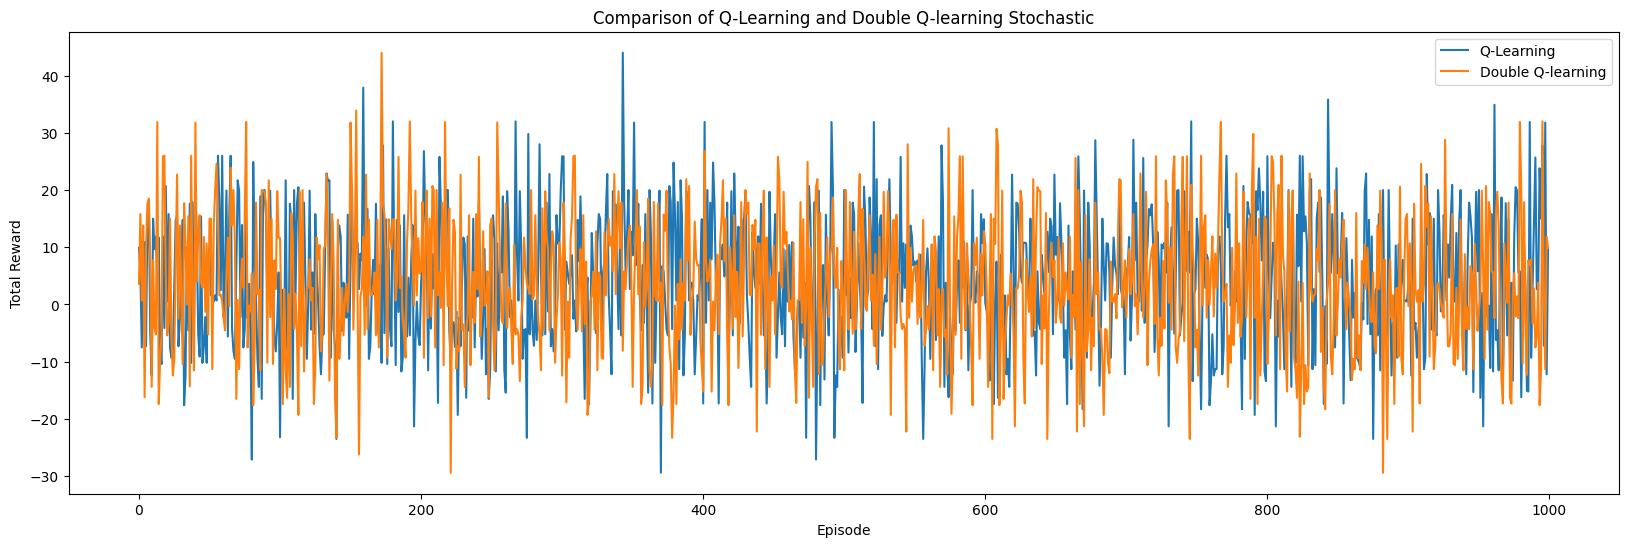

In [ ]:
plt.figure(figsize=(20, 6)) 
plt.plot(q_rewards, label='Q-Learning')
plt.plot(double_q_rewards, label='Double Q-learning')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.title('Comparison of Q-Learning and Double Q-learning Stochastic')
plt.show()